In [1]:
import random
from joblib import  load
import numpy as np
import numpy.ma as ma  

import pandas as pd

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences

import random
from collections import defaultdict
from typing import Tuple, Dict, List
import torch
# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
from torch import optim, nn, utils, transpose, device, cuda, save, isinf, backends, manual_seed, LongTensor, tensor, long
DEVICE = device(f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu')
from typing import Optional, Literal, List, Tuple, Union
from torch.optim import Adam
from pathlib import Path
from model.constants import MIN_LENGTH, MAX_LENGTH, VOCAB_SIZE

sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 6, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [2]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [3]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())

def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)

def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())


In [4]:
def select_peptides(results, mode):
    if mode=='pos':
        peptides = np.array(results[f'pos_peptides']).reshape(64, -1).T
        amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
        mic = results['pos_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmax(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )
    else:
        peptides = np.array(results['neg_peptides']).reshape(64, -1).T
        amp = (results['neg_class_prediction'] > 0.2).reshape(64, -1)
        mic = results['neg_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmin(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['neg_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['neg_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )

# Unconstrained

In [5]:
sequences = pd.read_csv('./sequences.csv', header=None)
sequences[0] = sequences[0].str.strip().str.rstrip("0")
df = sequences[~sequences[0].str.contains("0")]
generated = df[0].tolist()

In [6]:
#Get random peptides
random_gen = modlamp.sequences.Random(50000, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


In [7]:
class AMPDataManager:

    def __init__(
            self,
            positive_filepath: str,
            negative_filepath: str,
            min_len: int,
            max_len: int,
    ):
        self.positive_data = pd.read_csv(positive_filepath)
        self.negative_data = pd.read_csv(negative_filepath)

        self.min_len = min_len
        self.max_len = max_len

    def _filter_by_length(self, df: pd.DataFrame) -> pd.DataFrame:
        mask = (df['Sequence'].str.len() >= self.min_len) & (df['Sequence'].str.len() <= self.max_len)
        return df.loc[mask]

    def _filter_data(self):
        return self._filter_by_length(self.positive_data), self.negative_data

    @staticmethod
    def _get_probs(peptide_lengths: List[int]) -> Dict[int, float]:
        probs = defaultdict(lambda: 1)
        for length in peptide_lengths:
            probs[length] += 1
        return {k: round(v / len(peptide_lengths), 4) for k, v in probs.items()}

    @staticmethod
    def _draw_subsequences(df, new_lengths):
        # random.seed(44)
        new_lengths.sort(reverse=True)
        df = df.sort_values(by="Sequence length", ascending=False)

        d = []
        for row, new_length in zip(df.itertuples(), new_lengths):
            seq = row[2]
            curr_length = row[3]
            if new_length > curr_length:
                new_seq = seq
            elif new_length == curr_length:
                new_seq = seq
            else:
                begin = random.randrange(0, int(curr_length) - new_length)
                new_seq = seq[begin:begin + new_length]
            d.append(
                {
                    'Name': row[1],
                    'Sequence': new_seq,
                }
            )
        new_df = pd.DataFrame(d)
        return new_df

    def _equalize_data(self, positive_data: pd.DataFrame, negative_data: pd.DataFrame, balanced_classes: bool = True):
        positive_seq = positive_data['Sequence'].tolist()
        positive_lengths = [len(seq) for seq in positive_seq]

        negative_seq = negative_data['Sequence'].tolist()
        negative_lengths = [len(seq) for seq in negative_seq]
        negative_data.loc[:, "Sequence length"] = negative_lengths

        probs = self._get_probs(positive_lengths)
        k = len(positive_lengths) if balanced_classes else len(negative_lengths)

        new_negative_lengths = random.choices(list(probs.keys()), probs.values(), k=k)
        negative_data_distributed = self._draw_subsequences(self.negative_data, new_negative_lengths)
        return positive_data, negative_data_distributed

    def plot_distributions(self, equalize: bool = True):
        if equalize:
            pos_dataset, neg_dataset = self.get_data()
        else:
            pos_dataset, neg_dataset = self.positive_data, self.negative_data
        sns.set(color_codes=True)
        # TODO: figure out where this functionality should be. Goal is to plot distribution before and after baladancing
        positive_seq = pos_dataset['Sequence'].tolist()
        positive_lengths = [len(seq) for seq in positive_seq]

        negative_seq = neg_dataset['Sequence'].tolist()
        negative_lengths = [len(seq) for seq in negative_seq]

        fig, (ax2, ax3) = plt.subplots(figsize=(12, 6), ncols=2)
        sns.distplot(positive_lengths, ax=ax2)
        sns.distplot(negative_lengths, ax=ax3)
        ax2.set_title("Positive")
        ax3.set_title("Negative")

        plt.show()

    def _join_datasets(self, pos_dataset: pd.DataFrame, neg_dataset: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        pos_dataset.loc[:, 'Label'] = 1
        neg_dataset.loc[:, 'Label'] = 0
        merged = pd.concat([pos_dataset, neg_dataset])
        x = np.asarray(merged['Sequence'].tolist())
        y = np.asarray(merged['Label'].tolist())
        return x, y

    def get_data(self, balanced: bool = True):
        pos_dataset, neg_dataset = self._filter_data()
        return self._equalize_data(pos_dataset, neg_dataset, balanced_classes=balanced)

    def get_merged_data(self, balanced: bool = True):
        pos_dataset, neg_dataset = self.get_data(balanced=balanced)
        return self._join_datasets(pos_dataset, neg_dataset)

In [8]:
def set_seed(seed: int = 42) -> None:
    """
    Source:
    https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
    """
    np.random.seed(seed)
    random.seed(seed)
    manual_seed(seed)
    cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    backends.cudnn.deterministic = True
    backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    # logger.info(f"Random seed set to {seed}")
    return None
set_seed()

data_manager = AMPDataManager(
    './data/unlabelled_positive.csv',
    './data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
df = amp_x.tolist()

C:\Users\olagw\AppData\Local\Temp\ipykernel_23408\3809696541.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_dataset.loc[:, 'Label'] = 1


In [9]:
def calculate_physchem(peptides, datasets):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []


    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [10]:
datasets = [
    'Random',
    'Baseline',
    'Generated'
]

peptides = [
    random_peptides,
    df,
    generated
]

In [11]:
df[0]

'VTSWSLCTPGCTSPGGGSNCSFCC'

In [12]:
physchem = calculate_physchem(peptides, datasets)

In [13]:
physchem_temp = physchem.loc[:, ['pi', 'charge', 'hm', 'aromacity', 'dataset']]
physchem_quantiles = physchem_temp.groupby('dataset').quantile([0.25, 0.5, 0.75])
physchem_quantiles.to_csv('Supp_SourceData_FigureS1_quantiles.csv')

In [56]:
datasets = [
    ['Random','Baseline','Generated']
]

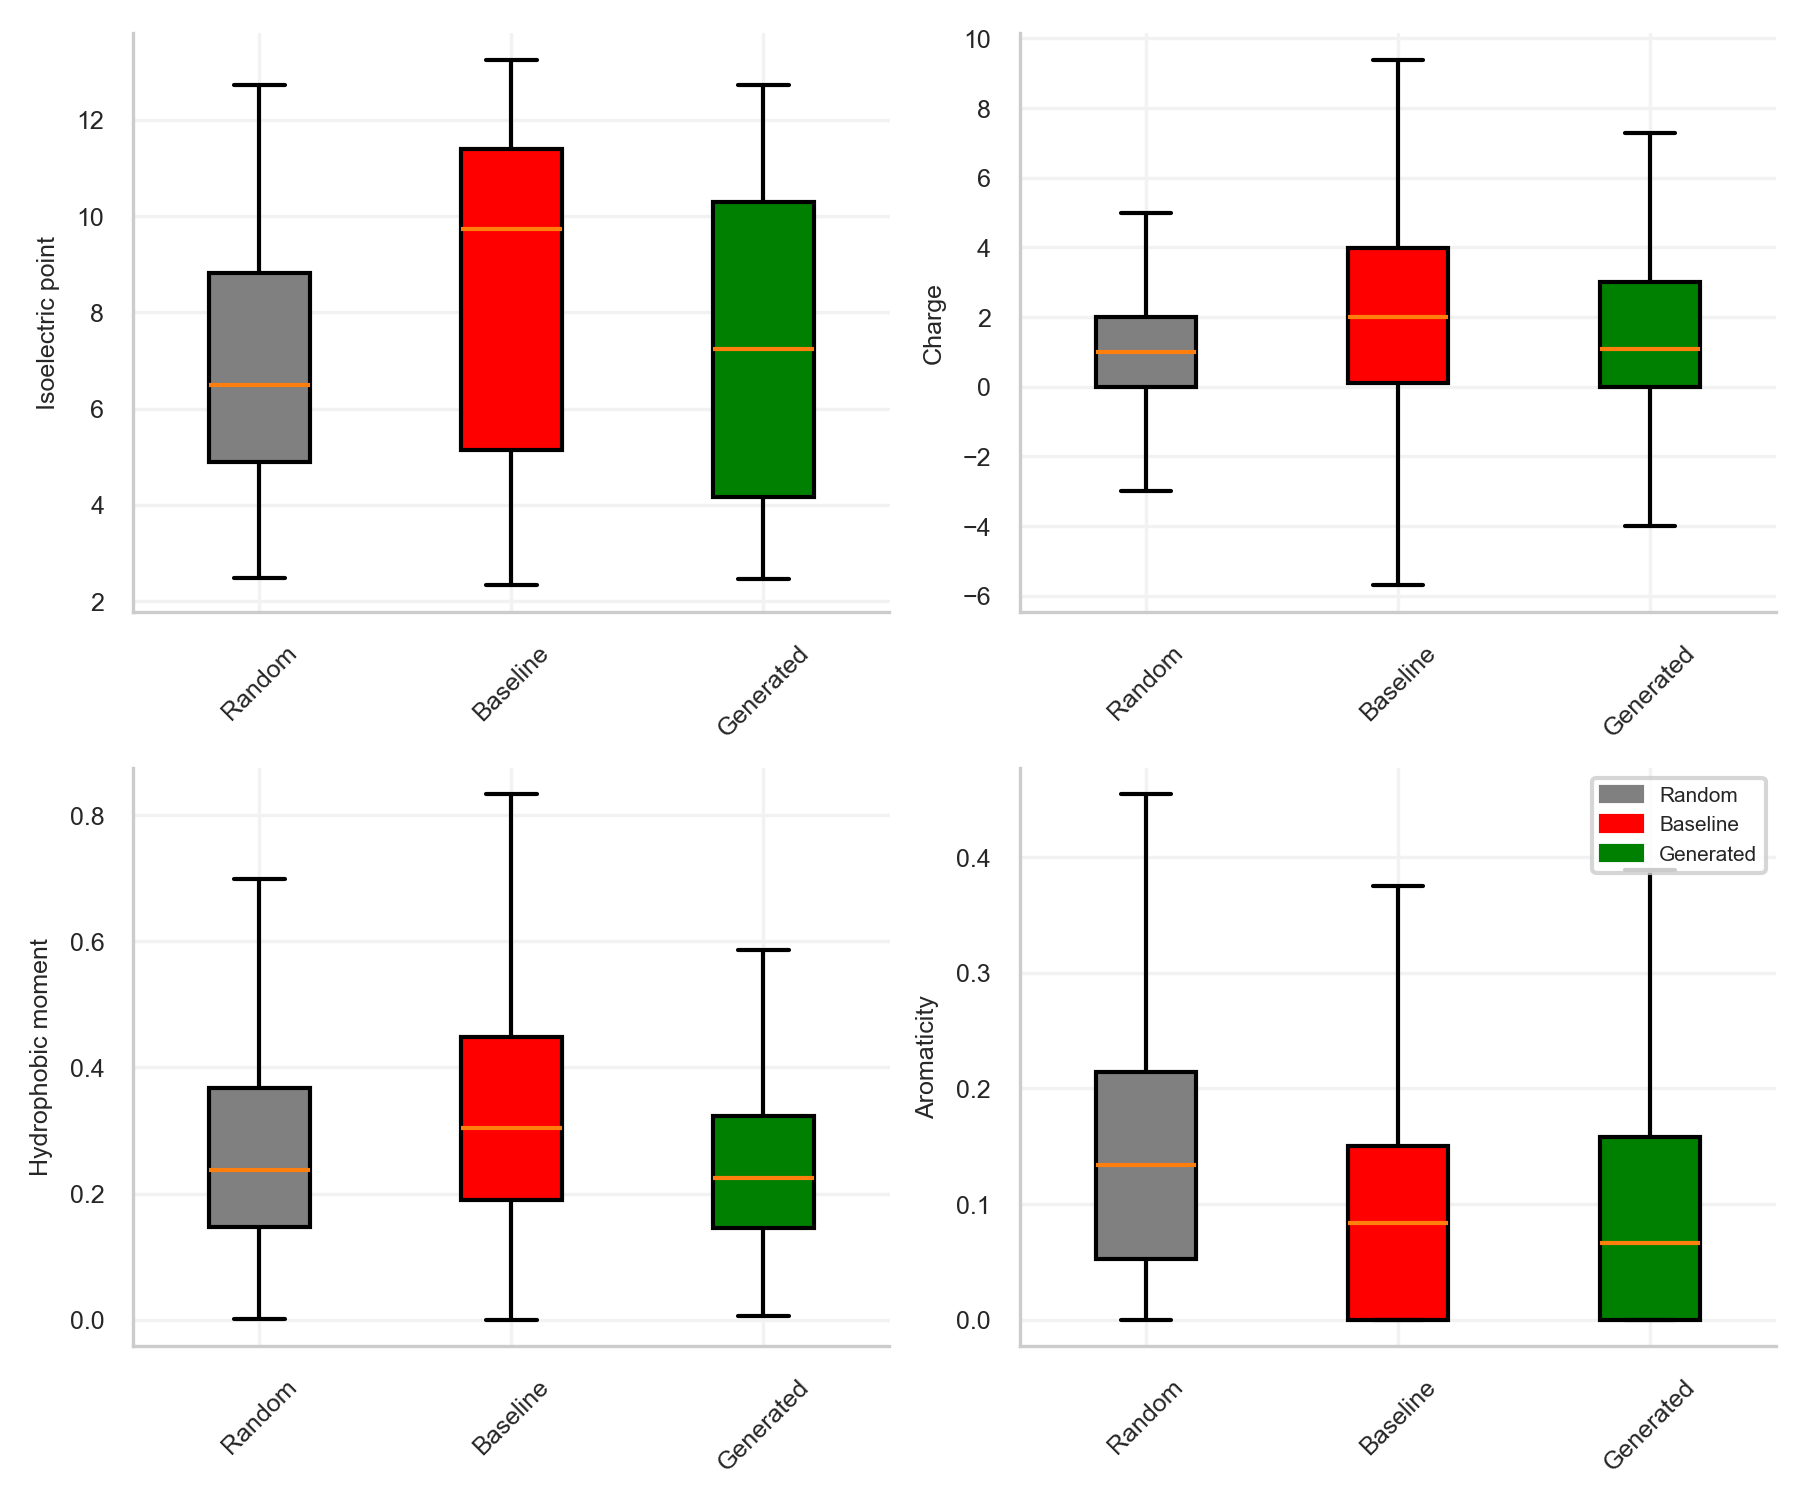

In [64]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Random', 'Baseline', 'Generated']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.boxplot(
        filtered_data,
        showfliers=False,
        patch_artist=True,
        widths=0.4
    )
    
    # Apply colors
    for patch, color in zip(parts['boxes'], ['grey', 'red', 'green']):
        patch.set_facecolor(color)
    
    # Set labels
    ax.set_xticks([1, 2, 3])  
    ax.set_xticklabels(['Random', 'Baseline', 'Generated'], rotation=45)
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='grey', label='Random'),    
        mpatches.Patch(color='red', label='Baseline'),
        mpatches.Patch(color='green', label='Generated'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

TypeError: list indices must be integers or slices, not str

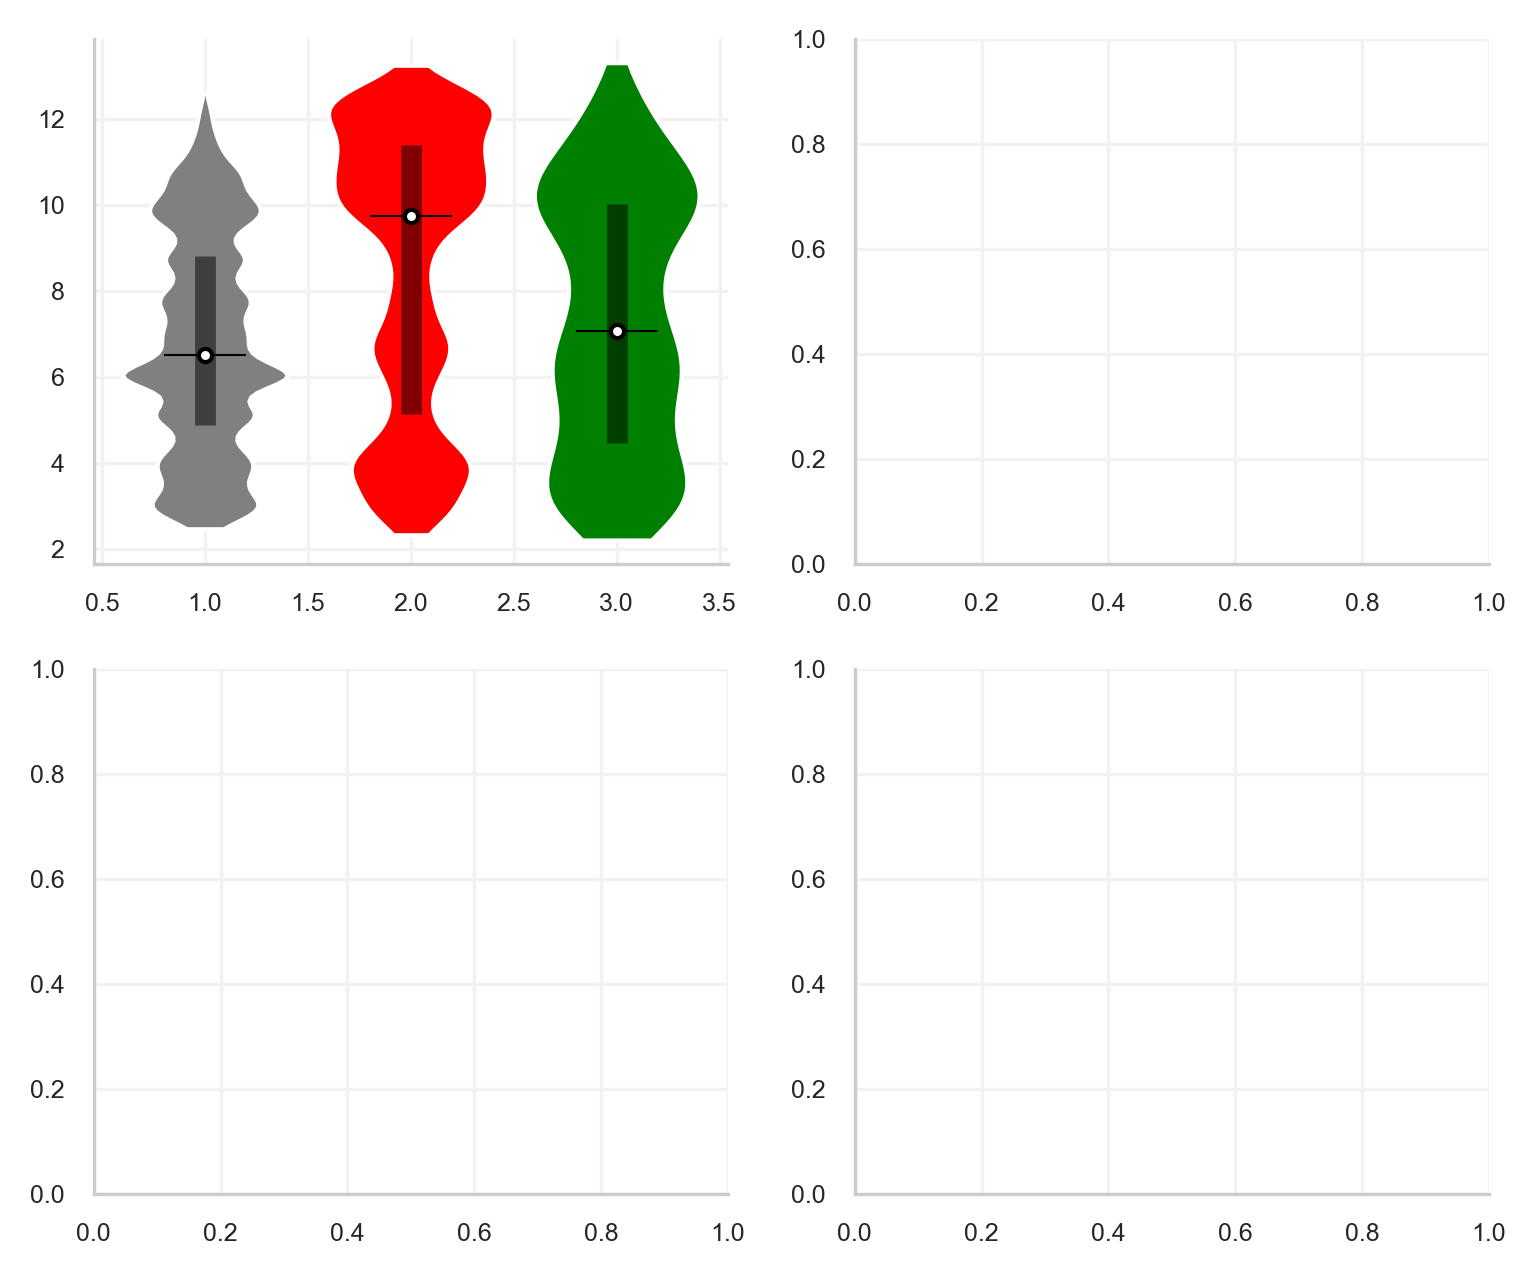

In [20]:

fig, _axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)
axes = [_axes[0][0], _axes[0][1], _axes[1][0], _axes[1][1]]
# Define properties and labels
properties = ['pi', 'charge', 'hm', 'length']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Length']

# Only use "Random" and "Generated"
selected_datasets = ['Random', 'Baseline', 'Generated']

for prop, label, ax in zip(properties, labels, axes):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    parts = ax.violinplot(
        filtered_data,
        showmeans=False,
        showmedians=True,
        showextrema=False,
        widths=0.8,
        bw_method='silverman',
        points=100,
    )

    # Apply colors
    for patch, color in zip(parts['bodies'], ['grey', 'red', 'green']):
        patch.set_facecolor(color)
        patch.set_alpha(1)

    # Customize median line if needed
    if 'cmedians' in parts:
        parts['cmedians'].set_color(medianprops.get('color', 'black'))
        parts['cmedians'].set_linewidth(medianprops.get('linewidth', 1.5))
        
    # Add Q1 and Q3 lines manually
    for i, dataset in enumerate(filtered_data):
        q1 = np.percentile(dataset, 25)
        q2 = np.percentile(dataset, 50)
        q3 = np.percentile(dataset, 75)
        
        # Box width
        box_width = 0.2
        x = i + 1

        # Box: vertical line (Q1 to Q3)
        ax.vlines(x, q1, q3, color='black', linewidth=5, alpha=0.5)

        # White dot at median
        ax.scatter(x, q2, facecolor='white', edgecolor='black', s=10, zorder=4)

    ax.set_ylabel(f"{properties[prop]}")
    axes.set_xticklabels([])
        
    all_values = np.concatenate(filtered_data)
    ymin = np.quantile(all_values, 0.005)
    ymax = np.quantile(all_values, 0.995)
    yrange = ymax - ymin
    padding = yrange * 0.1 if yrange > 0 else 1
    ax.set_ylim(ymin - padding, ymax + padding)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='grey', label='Random'),    
        mpatches.Patch(color='red', label='Baseline'),
        mpatches.Patch(color='green', label='Generated'),
    ], 
    loc='upper right'
)
for ax in [_axes[3][0], _axes[3][1]]:
    ax.set_xticks(range(1, len(datasets.keys()) + 1))
    ax.xaxis.set_ticks_position('none') 
    ax.set_xticklabels(filtered_data.values(), rotation=90)
# Save & Show Plot
# fig.savefig("./Filtered_Random_Uniprot.svg")
# fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

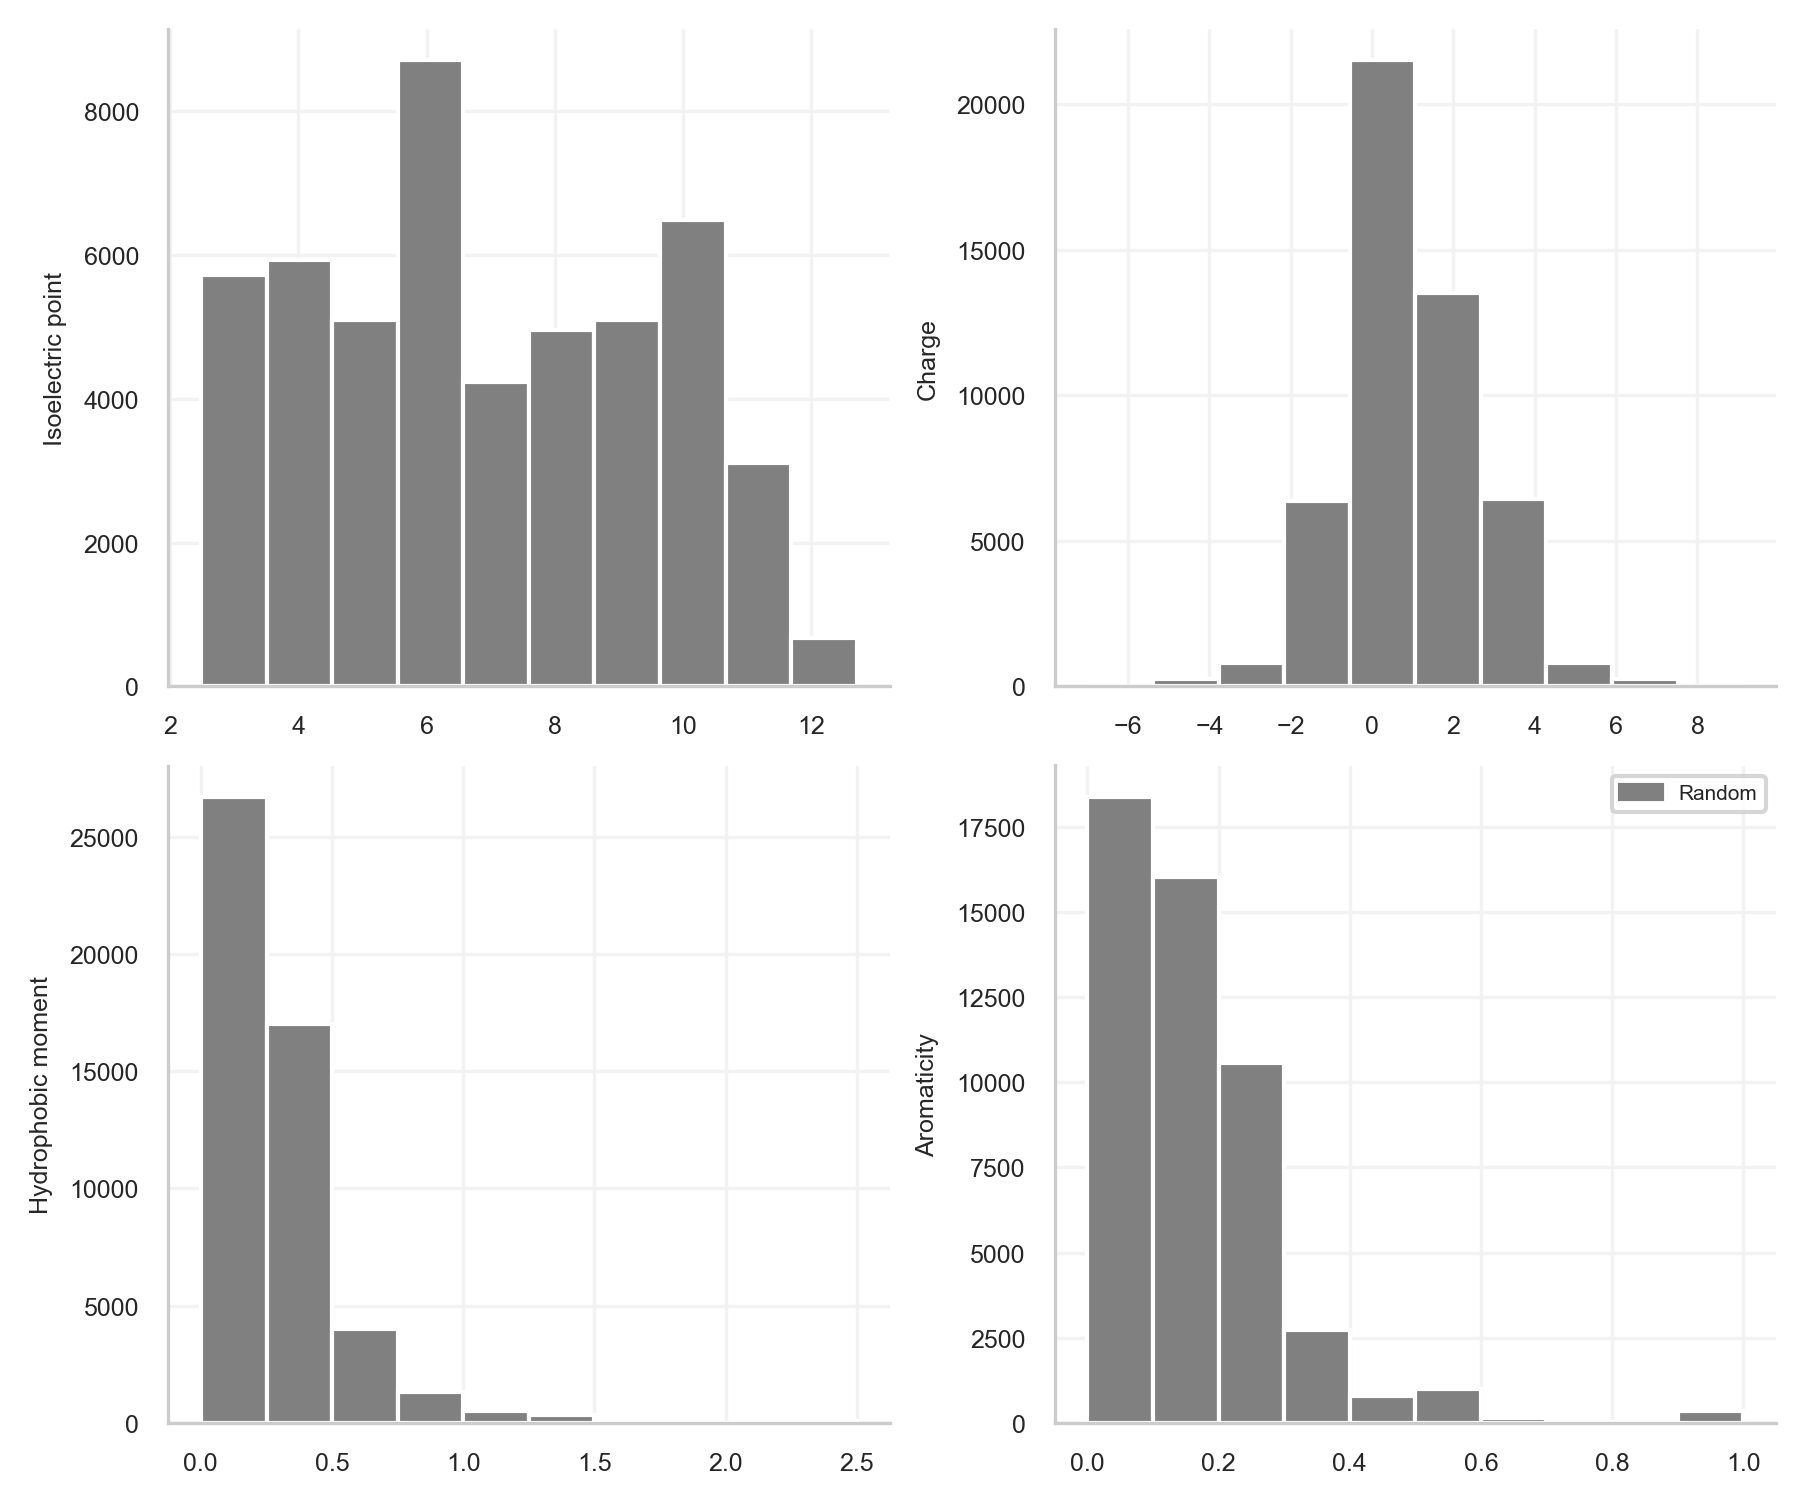

In [72]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Random']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['grey'], label=['Random']
    )
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='grey', label='Random'),    

    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

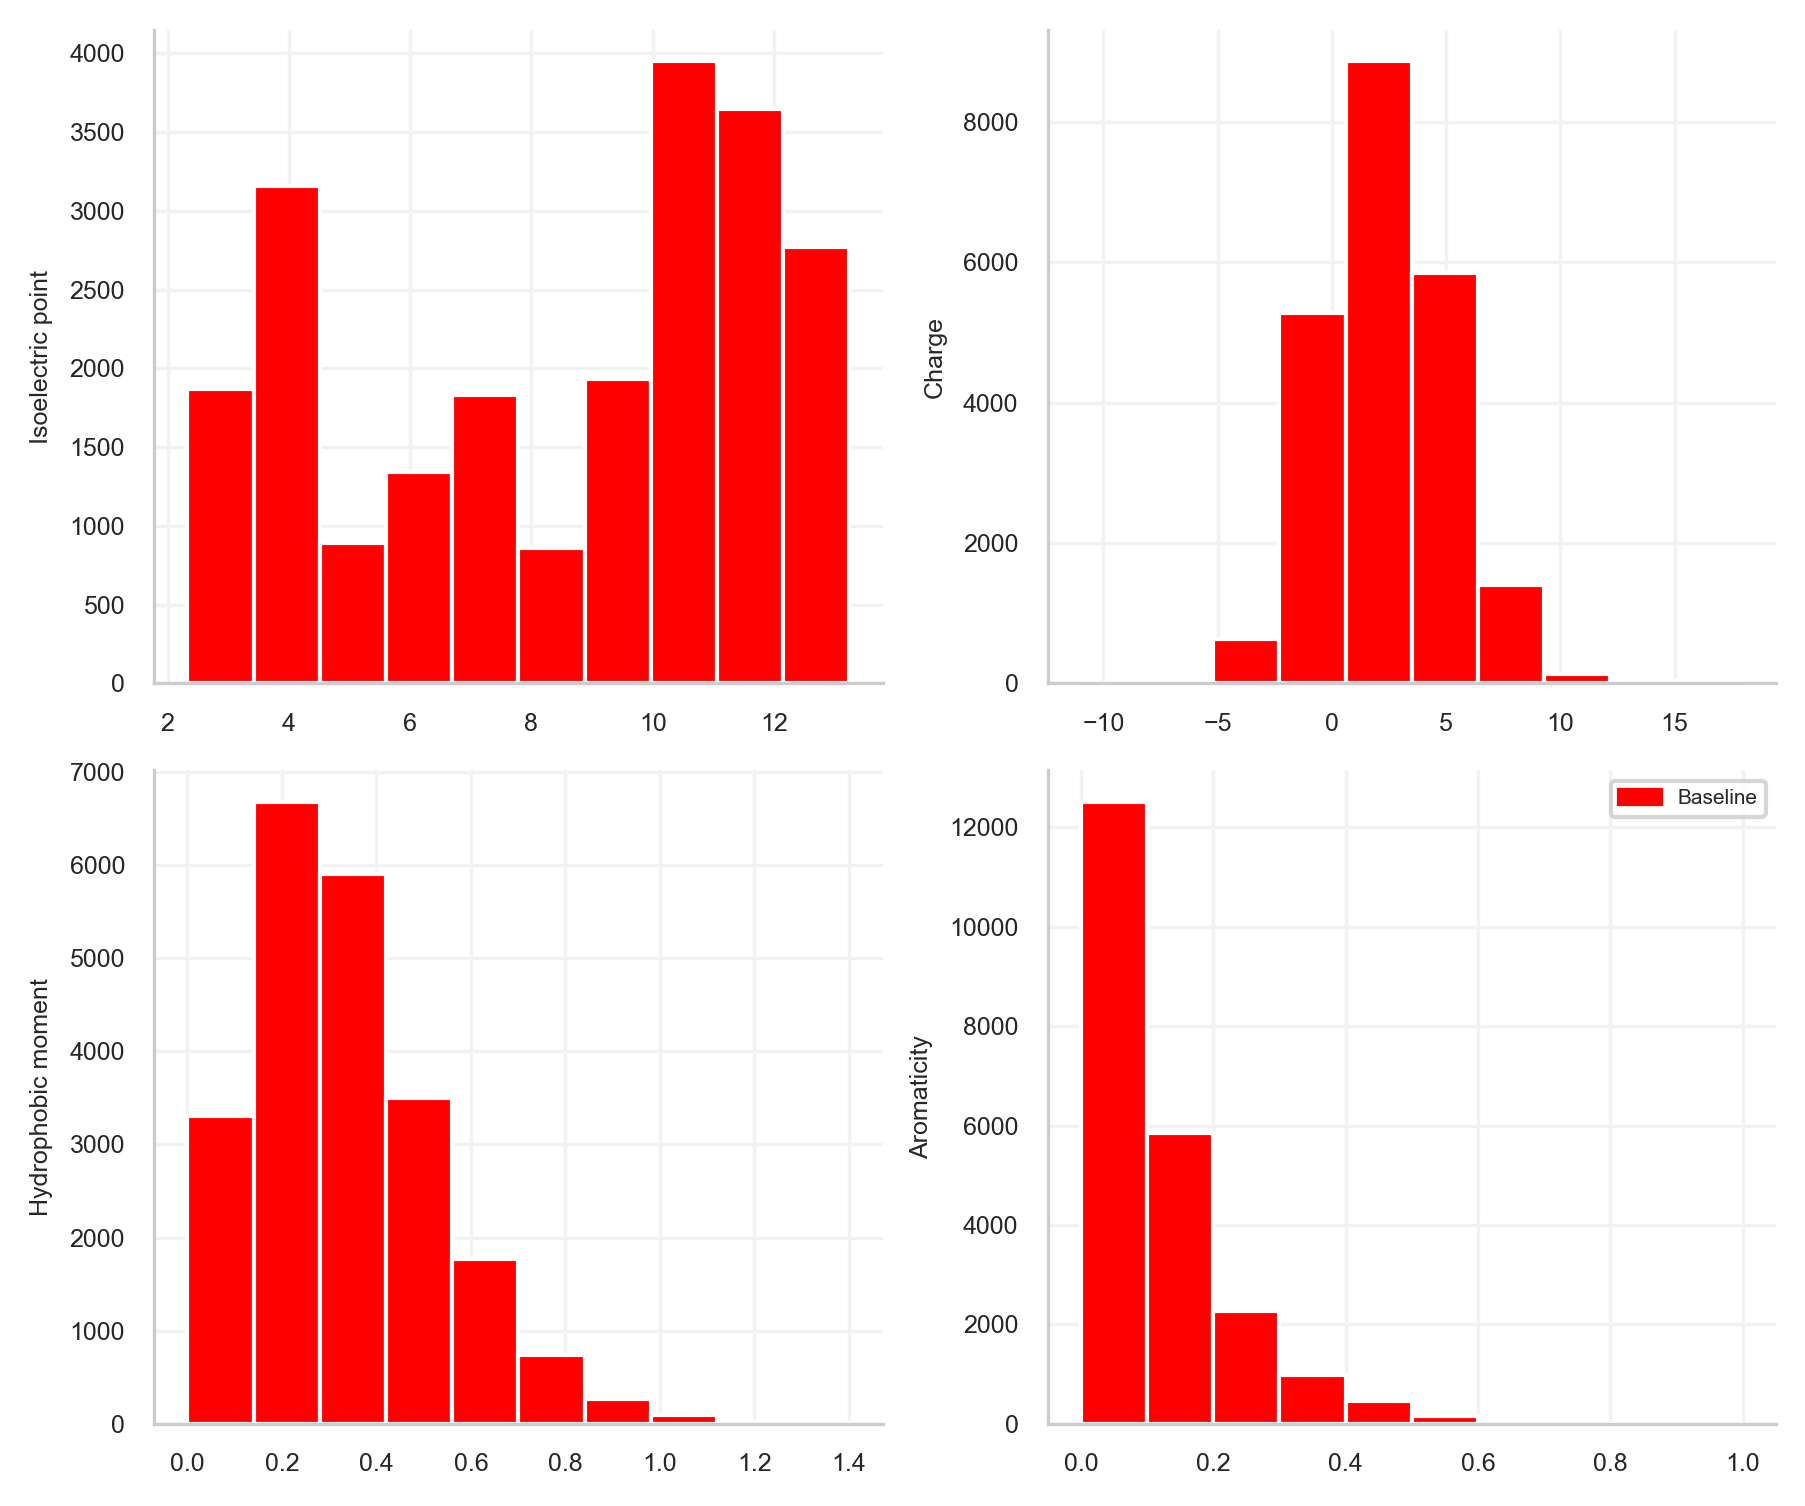

In [71]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Baseline']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['red'], label=['Baseline']
    )
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='red', label='Baseline'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

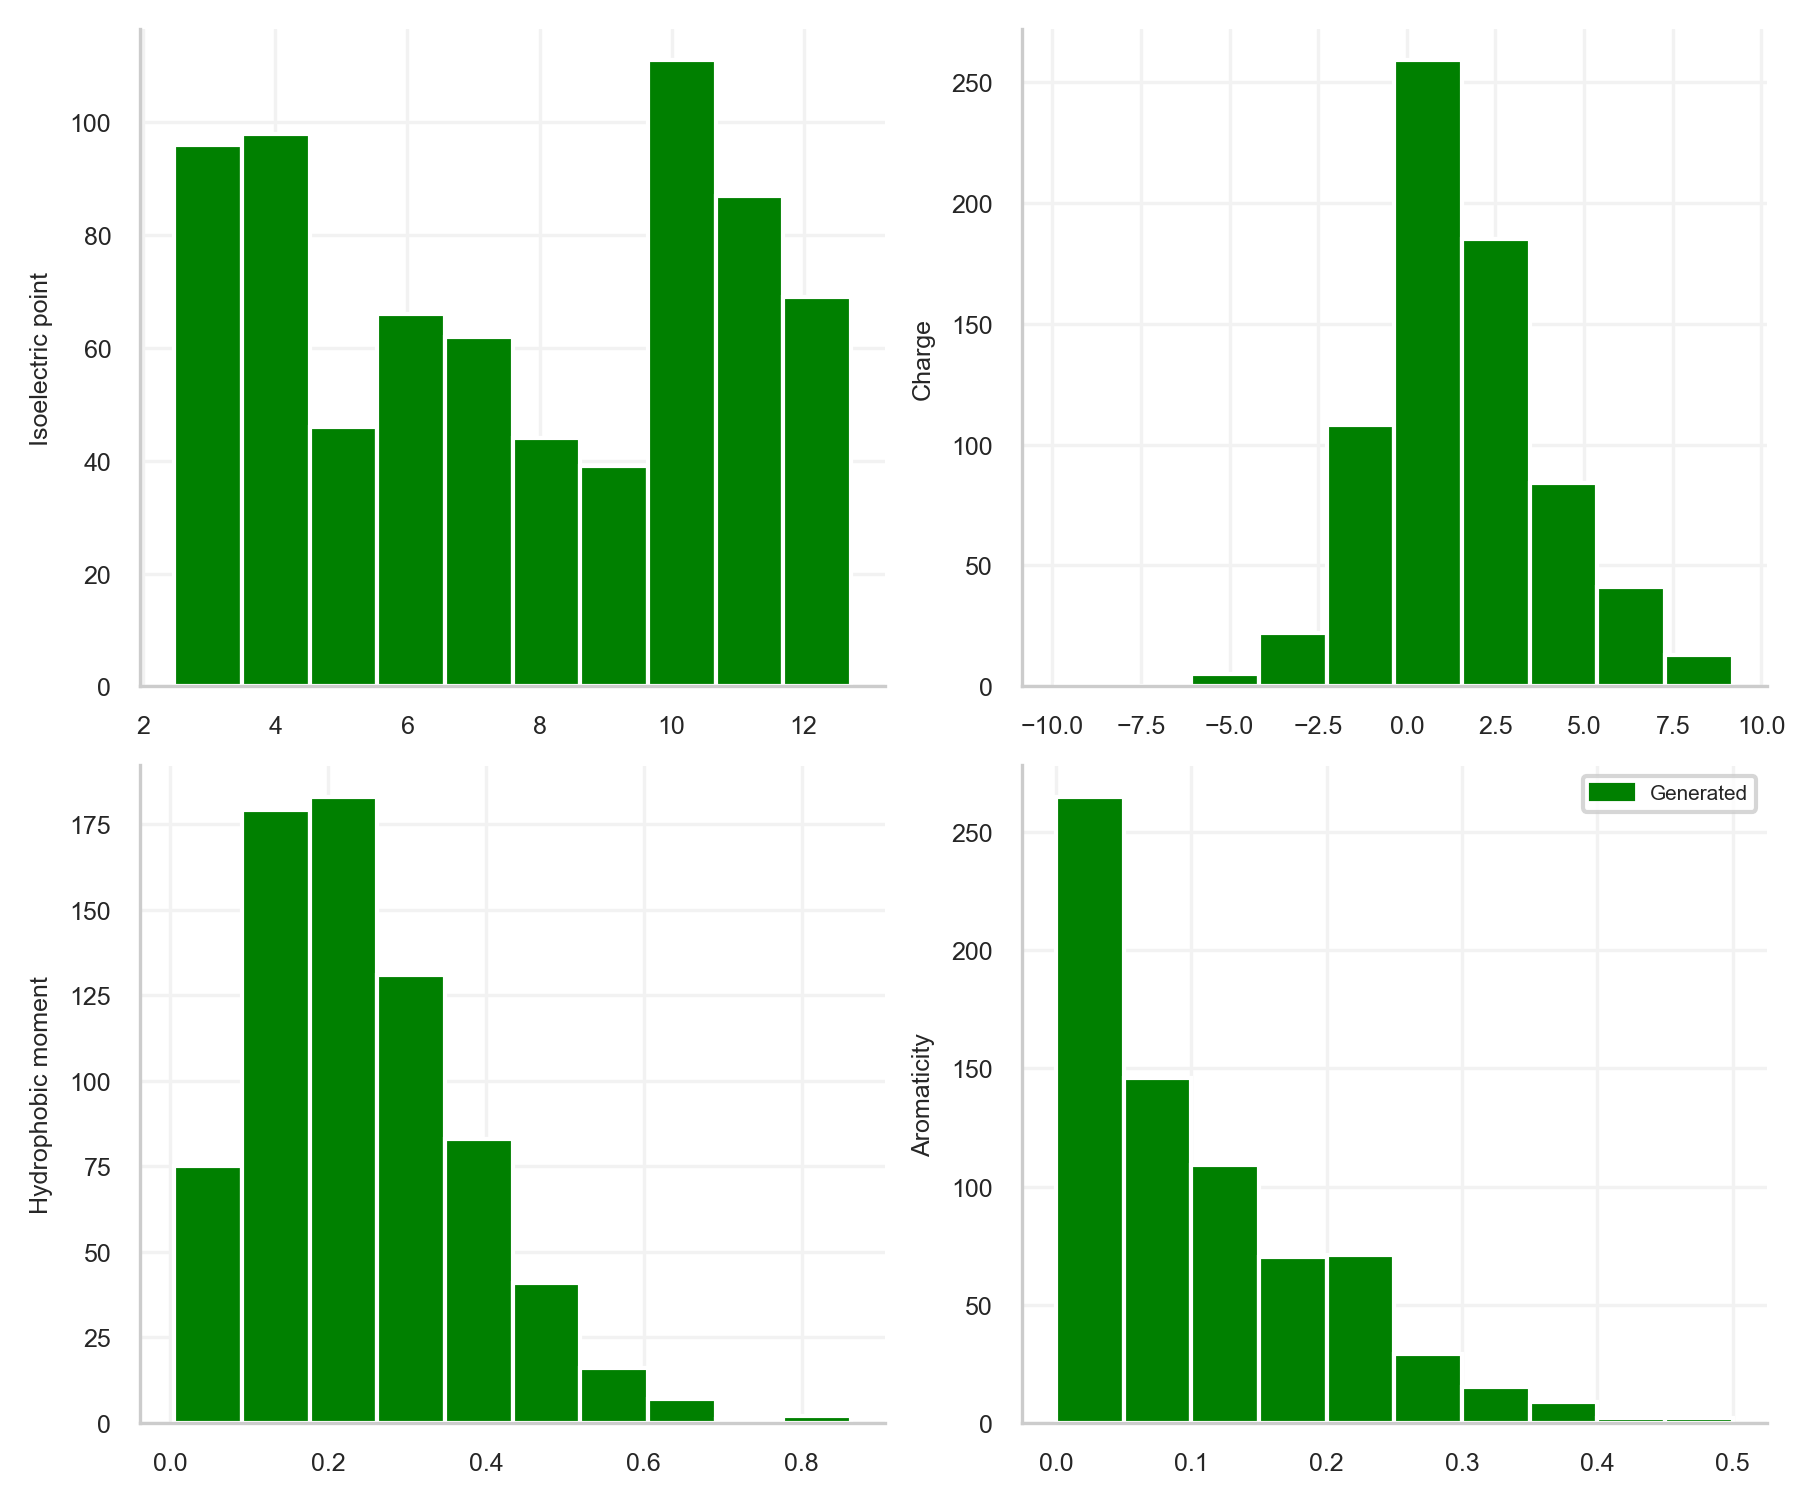

In [70]:
fig, axes = plt.subplots(
    ncols=2, 
    nrows=2,
    figsize=(6, 5),
    dpi=300,
)

# Define properties and labels
properties = ['pi', 'charge', 'hm', 'aromacity']
labels = ['Isoelectric point', 'Charge', 'Hydrophobic moment', 'Aromaticity']

# Only use "Random" and "Generated"
selected_datasets = ['Generated']

for prop, label, ax in zip(properties, labels, axes.flatten()):
    # Extract only "Random" and "Generated" data
    filtered_data = [
        physchem.loc[physchem['dataset'] == dataset, prop].tolist()
        for dataset in selected_datasets
    ]
    
    # Create boxplot
    parts = ax.hist(
        filtered_data,
        color= ['green'], label=['Generated']
    )
    
    ax.set_ylabel(label)

# Adjust layout
plt.tight_layout()

# Add legend
plt.legend(
    handles=[
        mpatches.Patch(color='green', label='Generated'),
    ], 
    loc='upper right'
)

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

In [14]:
from decimal import getcontext
STD_AA = list('ACDEFGHIKLMNPQRSTVWY')
loop = [STD_AA[i:i+1][0] for i in range(0, len(STD_AA), 1)]
getcontext().prec = 3

freq_random = {}
freq_baseline = {}
freq_generated = {}

all_amino_random = sum(len(s) for s in random_peptides)
all_amino_baseline = sum(len(s) for s in df)
all_amino_generated = sum(len(s) for s in generated)
for amino in loop:
    freq_random[amino] = sum(s.count(amino) for s in random_peptides)/all_amino_random
    freq_baseline[amino] = sum(s.count(amino) for s in df)/all_amino_baseline
    freq_generated[amino] = sum(s.count(amino) for s in generated)/all_amino_generated

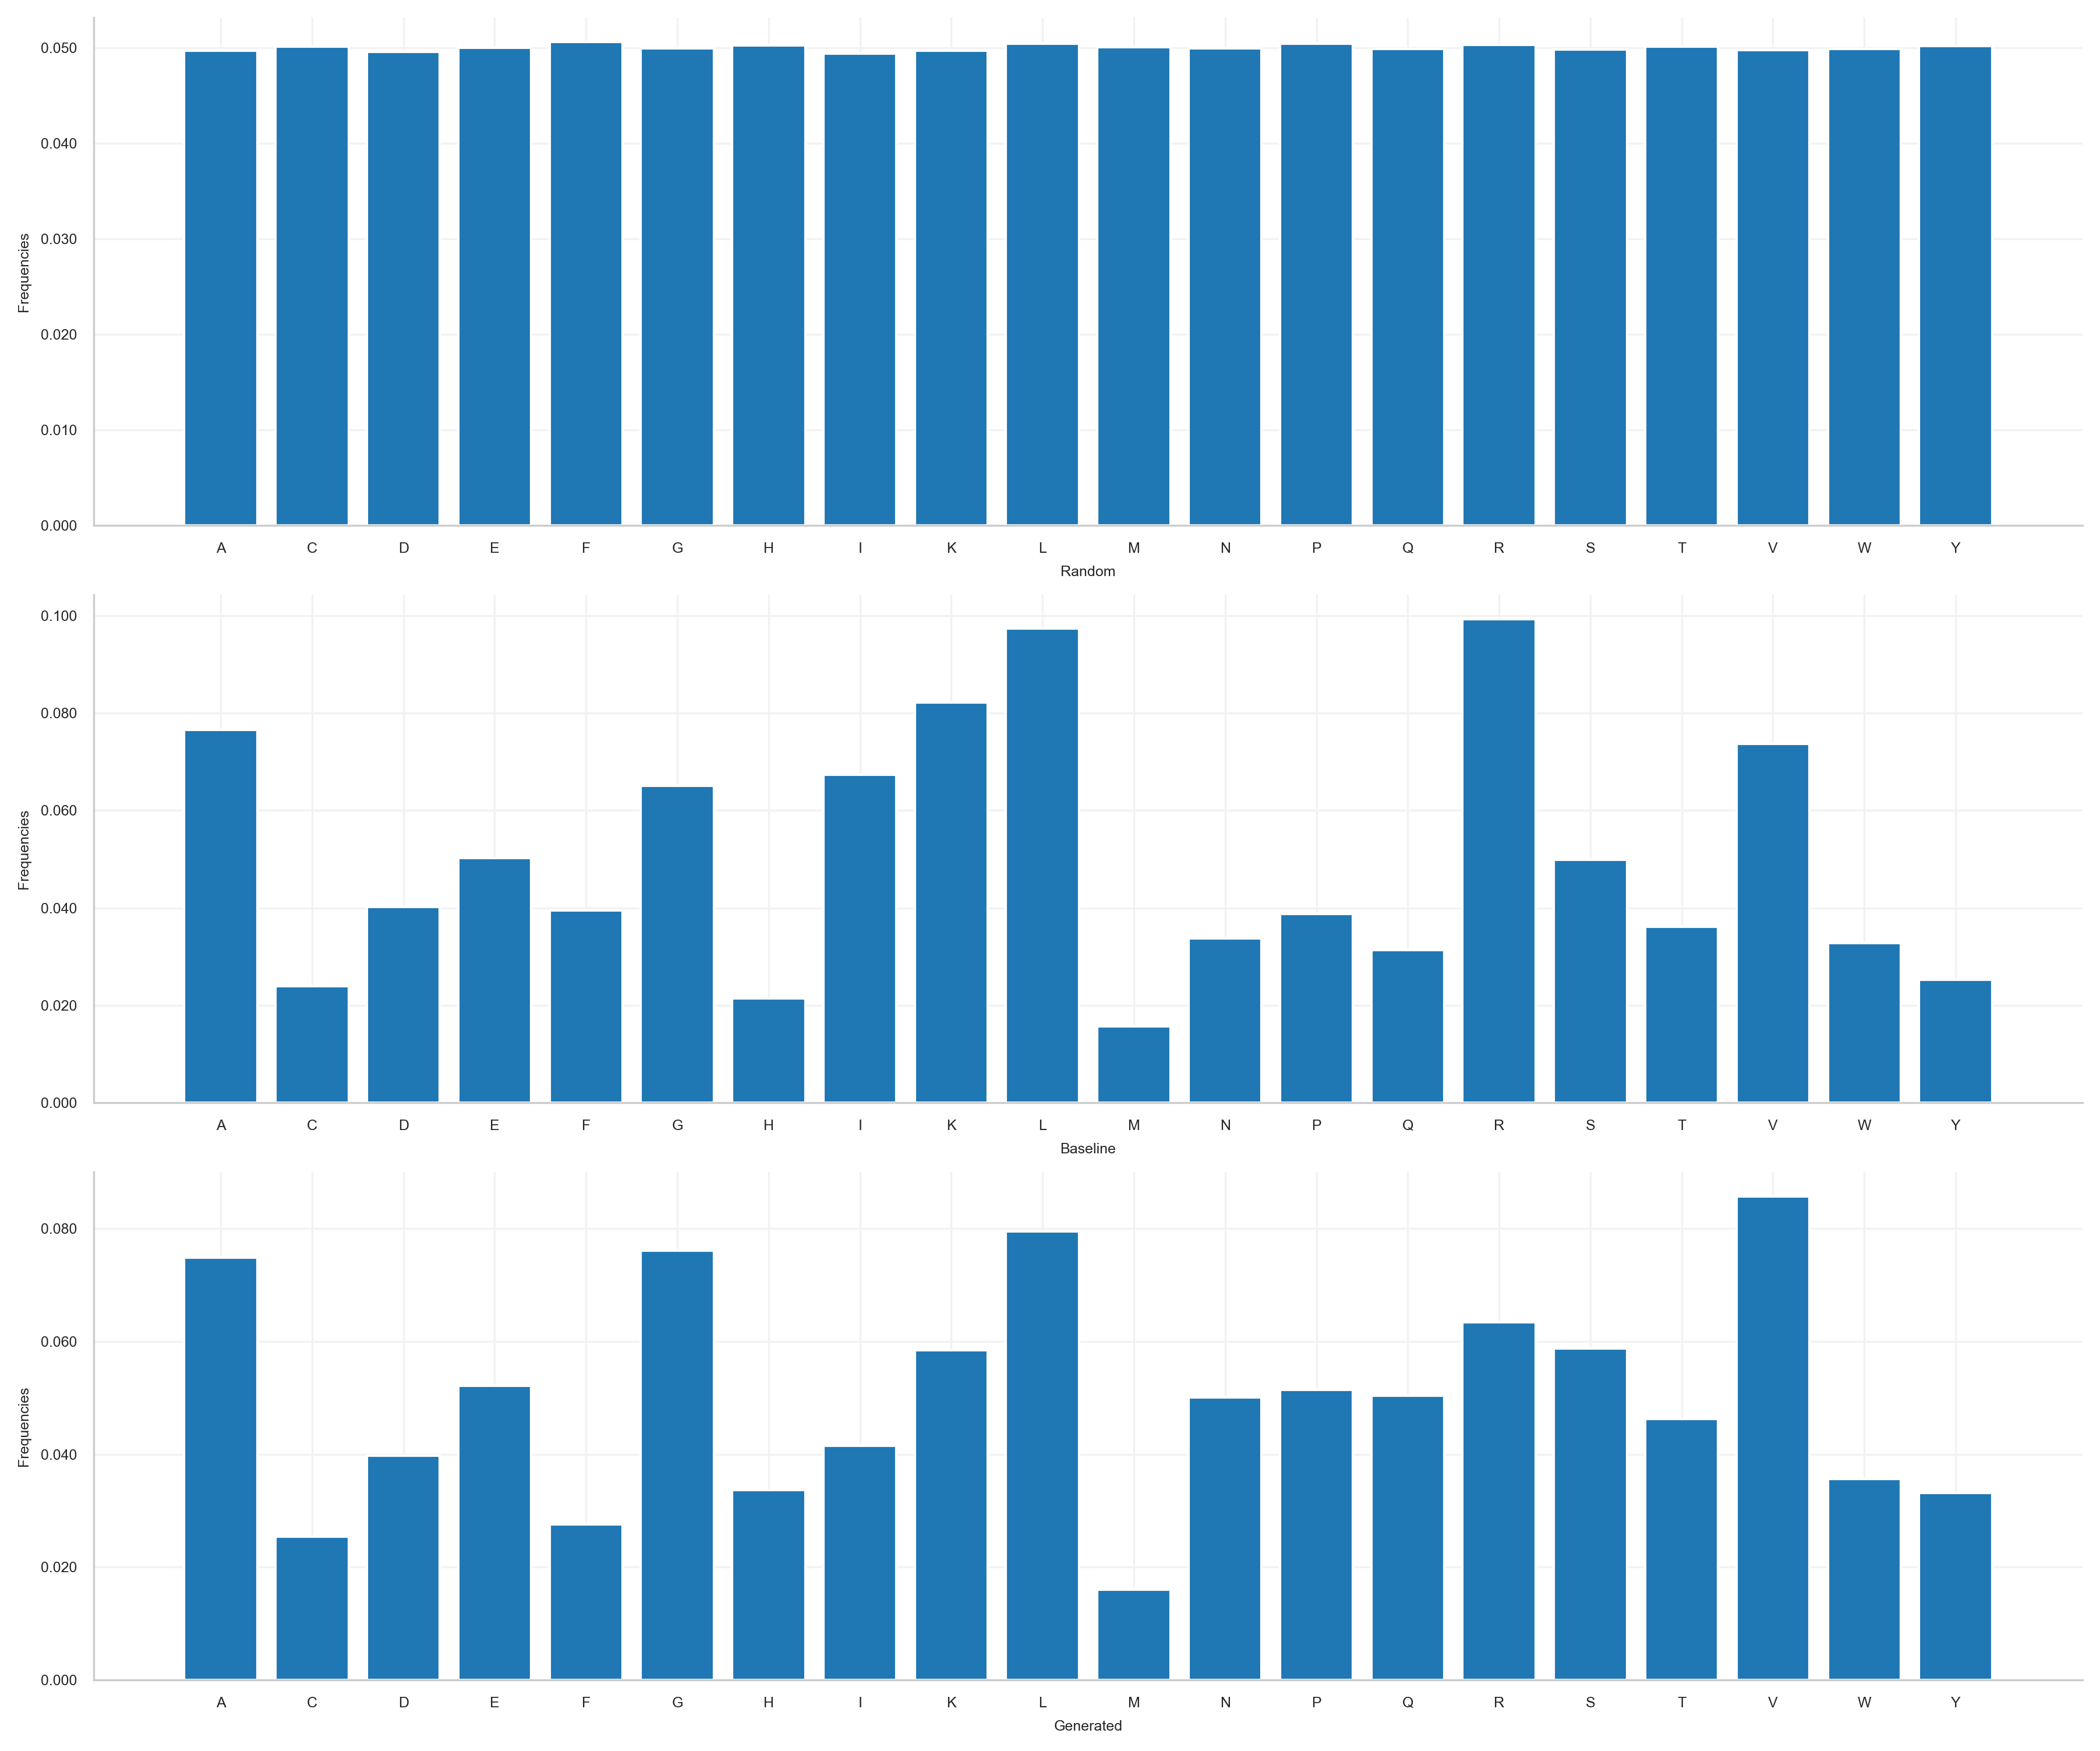

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(
    ncols=1, 
    nrows=3,
    figsize=(12, 10),
    dpi=300,
)

# Only use "Random" and "Generated"
selected_datasets = ['Random', 'Baseline', 'Generated']

for data, name, ax in zip([freq_random, freq_baseline, freq_generated],['Random', 'Baseline', 'Generated'], axes.flatten()):
    
    ax.bar(data.keys(), data.values())
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.set_xlabel(name)
    ax.set_ylabel('Frequencies')

# Adjust layout
plt.tight_layout()

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()

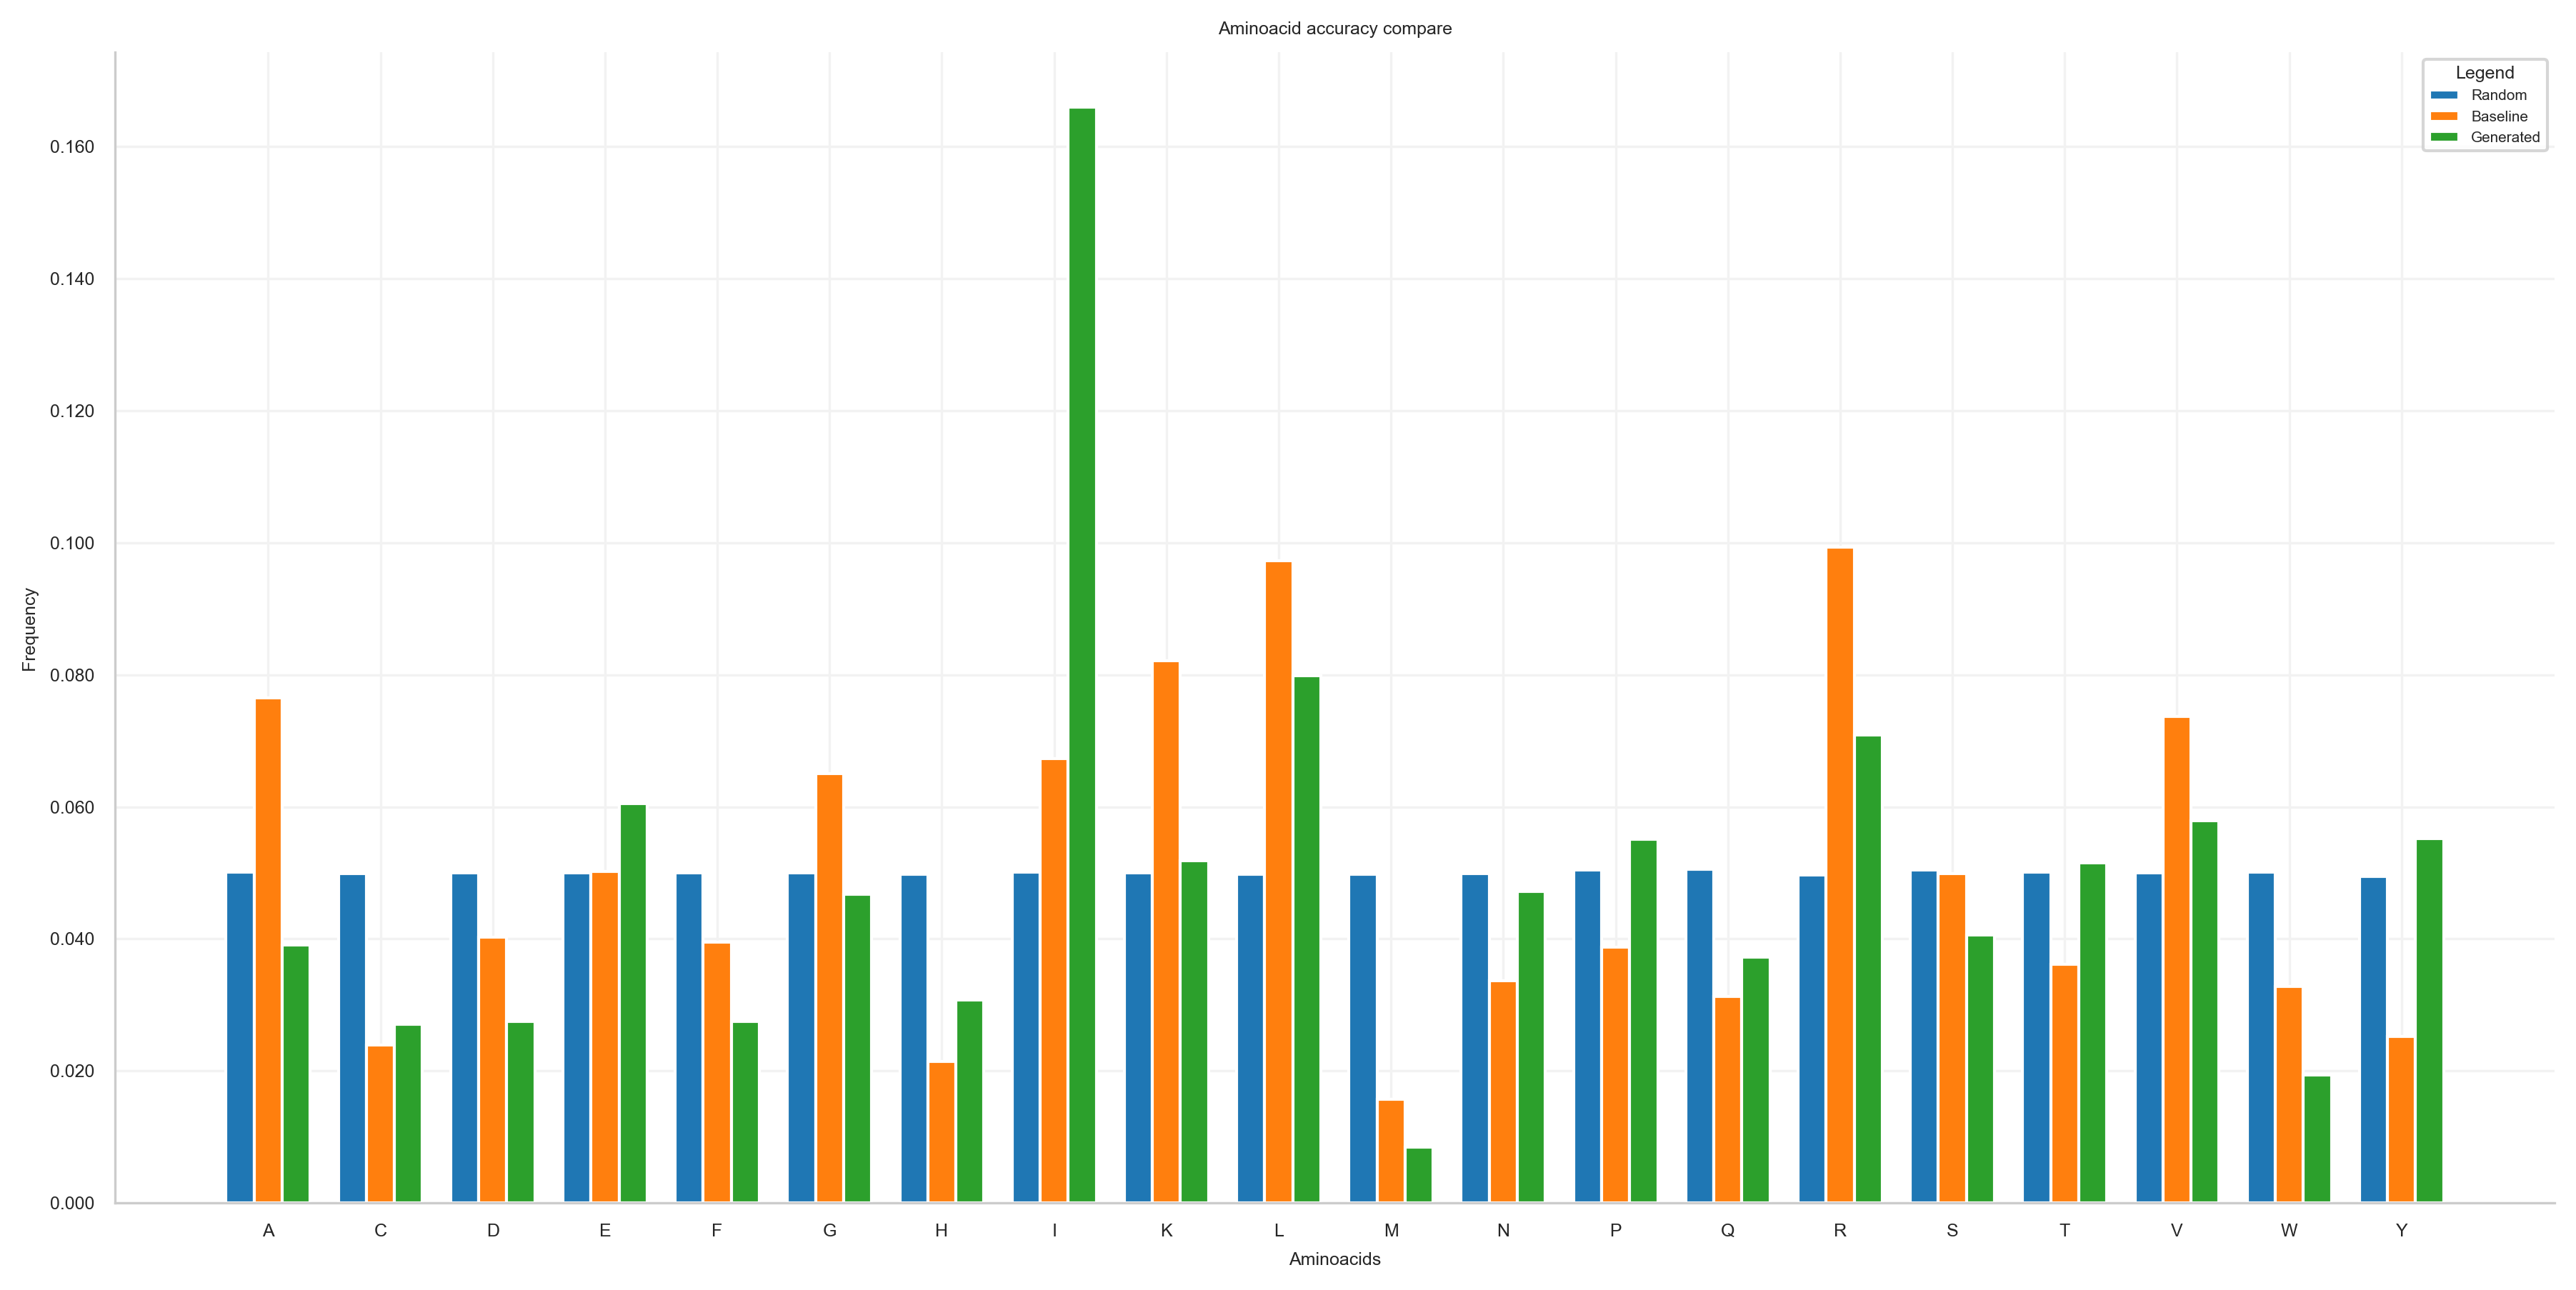

In [17]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(
    ncols=1, 
    nrows=1,
    figsize=(12, 6),
    dpi=300,
)
datasets = [freq_random, freq_baseline, freq_generated]
all_keys = sorted(list(set(key for d in datasets for key in d.keys())))
selected_datasets = ['Random', 'Baseline', 'Generated']
x = np.arange(len(all_keys))
for i, (data, name) in enumerate(zip(datasets,selected_datasets)):
    # Twórz wartości dla słupków w odpowiedniej kolejności all_keys
    values = [data.get(key, 0) for key in all_keys] # Użyj .get() na wypadek braku klucza
    
    # Przesuń pozycję słupków dla każdego zestawu danych
    ax.bar(x + i * 0.25, values, width=0.25, label=name)

# Ustaw etykiety osi X na środku grup słupków
ax.set_xticks(x + 0.25 * (len(datasets) - 1) / 2)
ax.set_xticklabels(all_keys)
# Formatowanie osi Y
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlabel('Aminoacids') # Ogólna etykieta dla osi X
ax.set_ylabel('Frequency')
ax.set_title('Aminoacid accuracy compare') # Dodaj tytuł

# Dodaj legendę, która pokaże, jaki kolor odpowiada którym danym
ax.legend(title="Legend")
# Adjust layout
plt.tight_layout()

# Save & Show Plot
fig.savefig("./Filtered_Random_Uniprot.svg")
fig.savefig("./Filtered_Random_Uniprot.pdf", bbox_inches="tight")
plt.show()